In [1]:
import h5py
import torch

# Replace 'your_file.h5' with the path to your HDF5 file
file_path = '/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3_scaled/dataset_2_1.hdf5'
data_dict = {}
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict[key] = torch.tensor(file[key][:])
        
    a_group_key = list(file.keys())[0]

    # Get the data
    data = list(file[a_group_key])

    # If you know the specific dataset you want to access, you can use
    # dataset = file['dataset_name']  # 'dataset_name' is the name of your dataset
    # data = dataset[:]  # Read the entire dataset

    # Now, 'data' is a NumPy array containing the dataset's contents


Keys: <KeysViewHDF5 ['incident_energies', 'showers']>


In [4]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose


hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

config=compose(config_name="config.yaml")

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [76]:
class DataManager(object):
    def __init__(self,train_loader=None,test_loader=None,val_loader=None, cfg=None):
        self._config=cfg
        
        self._train_loader=train_loader
        self._test_loader=test_loader
        self._val_loader=val_loader

        #this is a list of tensor.shape tuples (i.e.[(28,28)] for MNIST) 
        self._input_dimensions=None
        #list of flattened tensor.shape tuples (i.e. [784] for mnist)
        self._flat_input_sizes=None 

        self._train_dataset_means=None
        
        # Variables to be used in the scaling and inverse scaling
        self._amin_array = None
        self._transformer = None
        # return
        self.particle_type = [self._config.data.particle_type]
        self.frac_train_dataset=self._config.data.frac_train_dataset
        self.frac_test_dataset=self._config.data.frac_test_dataset
        self.load_dataset_directories()
        
        
    def load_dataset_directories(self):
        if self._config.data.data_type.lower()=="atlas":
            self.inFiles={
            'photon1':    self._config.data.atlas_input_photon1,
                'photonEn0':    self._config.data.atlas_input_photonEn0,
                'photonEn1':    self._config.data.atlas_input_photonEn1,
                'photonEn2':    self._config.data.atlas_input_photonEn2,
                'photonEn3':    self._config.data.atlas_input_photonEn3,
                'photonEn4':    self._config.data.atlas_input_photonEn4,
                'photonEn5':    self._config.data.atlas_input_photonEn5,
                'photonEn6':    self._config.data.atlas_input_photonEn6,
                'photonEn7':    self._config.data.atlas_input_photonEn7,
            'pion1':   self._config.data.atlas_input_pion1,
                'pionEn0':   self._config.data.atlas_input_pionEn0,
                'pionEn1':   self._config.data.atlas_input_pionEn1,
                'pionEn2':   self._config.data.atlas_input_pionEn2,
                'pionEn3':   self._config.data.atlas_input_pionEn3,
                'pionEn4':   self._config.data.atlas_input_pionEn4,
                'pionEn5':   self._config.data.atlas_input_pionEn5,
                'pionEn6':   self._config.data.atlas_input_pionEn6,
                'pionEn7':   self._config.data.atlas_input_pionEn7,
            'electron-ds2': self._config.data.atlas_input_electron,
        }
        
    def load_data(self):
        
        #read in all input files for all jet types and layers
        datastore={}
        for key,fpath in self.inFiles.items(): 
            if key in self.particle_type: 
                with h5py.File(fpath, 'r') as file:
                    # List all groups
                    # print("Keys: %s" % file.keys())
                    for other_key in file.keys():
                        datastore[other_key] = torch.tensor(file[other_key][:])
                
                # in_data=h5py.File(fpath,'r')
                # #for each particle_type, create a Container instance for our needs   
                # dataStore[key]=CaloImageContainer(  particle_type=key,
                #                                     input_data=in_data,
                #                                     layer_subset=layer_subset)
                # #convert image dataframes to tensors and get energies
                # dataStore[key].process_data(input_data=in_data)

        assert len(self.particle_type)==1, f"Currently one particle type at a time\
             can be retrieved. Requested {self.particle_type}"
        ptype=self.particle_type[0]

        #let's split our datasets
        #get total num evts
        num_evts_total=datastore['showers'].shape[0]
        print(num_evts_total)

        #create a sequential list of indices
        # idx_list = [i for i in range(0, num_evts_total)]

        # compute number of split evts from fraction
        num_evts_train = int(self.frac_train_dataset*num_evts_total)
        num_evts_test = int(self.frac_test_dataset*num_evts_total)

        #create lists of split indices
        # train_idx_list = idx_list[:num_evts_train]
        # test_idx_list = idx_list[num_evts_train:(num_evts_train+num_evts_test)]
        # val_idx_list = idx_list[(num_evts_train+num_evts_test):]

        # train_dataset = dataStore[ptype].create_subset(idx_list=train_idx_list, label="train")
        # test_dataset = dataStore[ptype].create_subset(idx_list=test_idx_list, label="test")
        # val_dataset = dataStore[ptype].create_subset(idx_list=val_idx_list, label="val")
        
        self.train_dataset =  TensorDataset(datastore['showers'][:num_evts_train,:], datastore['incident_energies'][:num_evts_train,:])
        self.test_dataset =  TensorDataset(datastore['showers'][num_evts_train:num_evts_train+num_evts_test,:], datastore['incident_energies'][num_evts_train:num_evts_train+num_evts_test,:])
        self.val_dataset =  TensorDataset(datastore['showers'][num_evts_train+num_evts_test:,:], datastore['incident_energies'][num_evts_train+num_evts_test:,:])

        return self.train_dataset, self.test_dataset, self.val_dataset
        
    def create_dataLoader(self):
        assert abs(self._config.data.frac_train_dataset-1)>=0, "Cfg option frac_train_dataset must be within (0,1]"
        assert abs(self._config.data.frac_test_dataset-0.99)>1.e-5, "Cfg option frac_test_dataset must be within (0,99]. 0.01 minimum for validation set"

        self.load_data()
                
        #create the DataLoader for the training dataset
        train_loader=DataLoader(   
            self.train_dataset,
            batch_size=self._config.engine.n_train_batch_size, 
            num_workers=self._config.num_workers,
            shuffle=True)

        #create the DataLoader for the testing/validation datasets
        #set batch size to full test/val dataset size - limitation only by hardware
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=self._config.engine.n_test_batch_size, 
            num_workers=self._config.num_workers,
            shuffle=False)
        
        val_loader = DataLoader(
            self.val_dataset,
            batch_size=self._config.engine.n_valid_batch_size, 
            num_workers=self._config.num_workers,
            shuffle=False)

        # logger.info("{0}: {2} events, {1} batches".format(train_loader,len(train_loader),len(train_loader.dataset)))
        # logger.info("{0}: {2} events, {1} batches".format(test_loader,len(test_loader),len(test_loader.dataset)))
        # logger.info("{0}: {2} events, {1} batches".format(val_loader,len(val_loader),len(val_loader.dataset)))

        return train_loader,test_loader,val_loader

In [77]:
dataMgr = DataManager(cfg=config)

In [78]:
tr, te, va = dataMgr.create_dataLoader()

100000


In [69]:
datastore['incident_energies']
tr

In [45]:
datastore['showers'][0:10,:]

tensor([[0.1841, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5740, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1179, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [35]:
from torch.utils.data import TensorDataset, DataLoader

In [36]:
ds = TensorDataset(datastore['showers'], datastore['incident_energies'])

In [38]:
loader = DataLoader(
    ds,
    batch_size=2
)

In [39]:
xx = next(iter(loader))

/raid/javier/anaconda3/lib/python3.11/site-packages/torch/distributed/distributed_c10d.py:347: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [11]:
# xx[1].shape
import matplotlib.pyplot as plt

(array([10046., 10027., 10073., 10101.,  9834., 10064.,  9920., 10039.,
        10026.,  9870.]),
 array([5.46838165e-04, 6.91247259e-01, 1.38194768e+00, 2.07264810e+00,
        2.76334852e+00, 3.45404894e+00, 4.14474936e+00, 4.83544978e+00,
        5.52615020e+00, 6.21685063e+00, 6.90755105e+00]),
 <BarContainer object of 10 artists>)

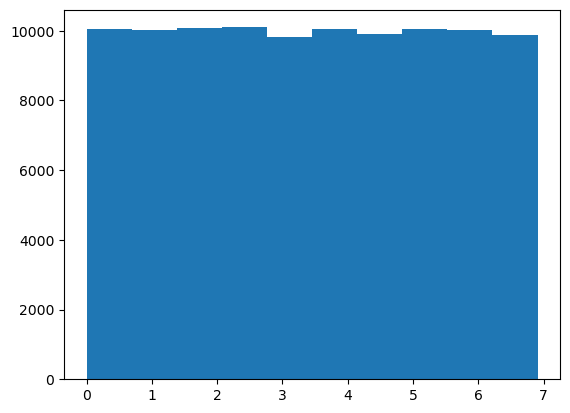

In [14]:
plt.hist(data_dict["incident_energies"].reshape(-1).divide(1000).log().numpy())